In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB2
# from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# mannequin_path = os.path.join('../','eventsData/training/mannequin')
# # not_mannequin_path = os.path.join('../','not_mannequin_filter')

# mannequin_img_path = [os.path.join(mannequin_path,x) for x in os.listdir(mannequin_path)]
# # not_mannequin_img_path = [os.path.join(not_mannequin_path,x) for x in os.listdir(not_mannequin_path)]

# print(mannequin_img_path[:5])
# # print(not_mannequin_img_path[:5])

# random.shuffle(mannequin_img_path)
# random.shuffle(mannequin_img_path)
# # random.shuffle(not_mannequin_img_path)
# # random.shuffle(not_mannequin_img_path)

# print(mannequin_img_path[:5])
# print(not_mannequin_img_path[:5])

In [3]:
# train_mannequin_img, test_mannequin_img = train_test_split(mannequin_img_path,test_size = 0.20,random_state=42)

In [4]:
train_datagen = IDG(rescale=1/255)
val_datagen = IDG(rescale=1/255)
test_datagen = IDG(rescale=1/255)

train_path = '../events100_gaussianMapping/data_filtered_final/training'
val_path = '../events100_gaussianMapping/data_filtered_final/validation'
test_path = '../events100_gaussianMapping/data_filtered_final/testing'
shape = (224,224,3)

In [5]:
train_generator = train_datagen.flow_from_directory(train_path,target_size=(shape[0],shape[1]),batch_size=32,class_mode='categorical',shuffle=True,seed=33,color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_path,target_size=(shape[0],shape[1]),batch_size=32,class_mode='categorical',shuffle=True,seed=33,color_mode='rgb')
test_generator = test_datagen.flow_from_directory(test_path,target_size=(shape[0],shape[1]),batch_size=32,class_mode='categorical')


Found 7892 images belonging to 2 classes.
Found 2631 images belonging to 2 classes.
Found 2632 images belonging to 2 classes.


In [6]:
a,b = train_generator.next()

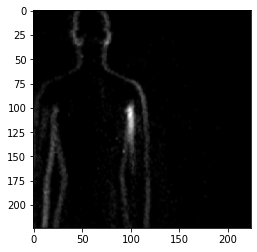

In [8]:
plt.imshow(a[1],cmap='gray')

In [9]:
efficientB2_model = MobileNetV2(include_top=False,weights='imagenet',input_shape=shape)
efficientB2_model.trainable=False
x = GlobalAveragePooling2D()(efficientB2_model.output)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2,activation='softmax')(x)

model = Model(efficientB2_model.input,x)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [10]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [11]:
history=model.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
247/247 [==============================] - 10s 42ms/step - loss: 0.2453 - accuracy: 0.8941 - val_loss: 0.1172 - val_accuracy: 0.9593
Epoch 2/20
247/247 [==============================] - 10s 41ms/step - loss: 0.0960 - accuracy: 0.9676 - val_loss: 0.0722 - val_accuracy: 0.9799
Epoch 3/20
247/247 [==============================] - 10s 41ms/step - loss: 0.0632 - accuracy: 0.9790 - val_loss: 0.0547 - val_accuracy: 0.9844
Epoch 4/20
247/247 [==============================] - 10s 41ms/step - loss: 0.0462 - accuracy: 0.9867 - val_loss: 0.0470 - val_accuracy: 0.9863
Epoch 5/20
247/247 [==============================] - 10s 41ms/step - loss: 0.0338 - accuracy: 0.9905 - val_loss: 0.0388 - val_accuracy: 0.9897
Epoch 6/20
247/247 [==============================] - 10s 40ms/step - loss: 0.0292 - accuracy: 0.9924 - val_loss: 0.0349 - val_accuracy: 0.9909
Epoch 7/20
247/247 [==============================] - 10s 40ms/step - loss: 0.0225 - accuracy: 0.9947 - val_loss: 0.0341 - val_accuracy:

In [13]:
model.save('mobilenetV2_softmax_GM_rescale.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mobilenetV2_softmax_GM_rescale/assets


In [ ]:
tf.saved_model.save(model,"mobilenetV2_softmax_GM_rescale")

In [ ]:
# from tensorflow.keras.models import load_model
# model_import = load_model('mobilenetV2.h5')